# 2.7 병렬 처리를 통한 효율 개선 (feat. 프롬프트 엔지니어링)

In [ ]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str  # 사용자 질문
    tax_rate: str  # (answer) 세율 -> calculate_tax_rate
    tax_base: str  # 과세표준 계산 -> calculate_tax_base
    tax_base_equation: str  # 과세표준 계산 수식 -> get_tax_base_equation
    tax_deduction: str  # 공제액 -> get_tax_deduction
    market_ratio: str  # 공정시장가액비율 -> get_market_ratio

workflow = StateGraph(AgentState)

In [3]:
# from langchain_community.document_loaders import PyPDFLoader
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# pdf_file_path = "./documents/real_estate_tax.pdf"
# pdf_loader = PyPDFLoader(file_path=pdf_file_path)
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=128)
# documents = pdf_loader.load_and_split(text_splitter=text_splitter)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

collection_name = "real_estate_tax"
embedding = HuggingFaceEmbeddings(model="BAAI/bge-m3")

# vector_store = Chroma.from_documents(
#     documents=documents,
#     embedding=embedding,
#     collection_name=collection_name,
#     persist_directory="./chroma"
# )

vector_store = Chroma(
    embedding_function=embedding,
    collection_name=collection_name,
    persist_directory="./chroma"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"
response = retriever.invoke(query)
print(response[0].page_content)

법제처                                                            4                                                       국가법령정보센터
종합부동산세법
1. 「상속세 및 증여세법」 제16조에 따른 공익법인등(이하 이 조에서 “공익법인등”이라 한다)이 직접 공익목적사업
에 사용하는 주택만을 보유한 경우와 「공공주택 특별법」 제4조에 따른 공공주택사업자 등 사업의 특성을 고려하
여 대통령령으로 정하는 경우: 제1항제1호에 따른 세율
2. 공익법인등으로서 제1호에 해당하지 아니하는 경우: 제1항 각 호에 따른 세율
3. 제1호 및 제2호 외의 경우: 다음 각 목에 따른 세율
가. 2주택 이하를 소유한 경우: 1천분의 27
나. 3주택 이상을 소유한 경우: 1천분의 50
③주택분 과세표준 금액에 대하여 해당 과세대상 주택의 주택분 재산세로 부과된 세액(「지방세법」 제111조제3항
에 따라 가감조정된 세율이 적용된 경우에는 그 세율이 적용된 세액, 같은 법 제122조에 따라 세부담 상한을 적용받
은 경우에는 그 상한을 적용받은 세액을 말한다)은 주택분 종합부동산세액에서 이를 공제한다.<신설 2005. 12. 31.,
2008. 12. 26., 2010. 3. 31.>
④주택분 종합부동산세액을 계산할 때 주택 수 계산 및 주택분 재산세로 부과된 세액의 공제 등에 관하여 필요한
사항은 대통령령으로 정한다.<신설 2005. 12. 31., 2018. 12. 31., 2020. 6. 9.>
⑤ 주택분 종합부동산세 납세의무자가 1세대 1주택자에 해당하는 경우의 주택분 종합부동산세액은 제1항ㆍ제3항
및 제4항에 따라 산출된 세액에서 제6항부터 제9항까지의 규정에 따른 1세대 1주택자에 대한 공제액을 공제한 금
액으로 한다. 이 경우 제6항부터 제9항까지는 공제율 합계 100분의 80의 범위에서 중복하여 적용할 수 있다.<신설
2008. 12. 26., 2018. 12. 31., 2020. 

In [6]:
from langchain_ollama import ChatOllama

# llm_llama32v = ChatOllama(model="llama3.2-vision")
llm_llama31 = ChatOllama(model="llama3.1")

- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [7]:
from langchain_classic import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

def get_tax_base_equation(state: AgentState) -> AgentState:
    """
    종합부동산세 과세표준을 계산하는 수식을 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.
    Args:
        state (AgentState): 현재 에이전트의 상태를 나타내는 객체입니다.
    Returns:
        AgentState: 'tax_base_equation' 키를 포함하는 새로운 `state`를 반환합니다.
    """
    print("get_tax_base_equation")

    rag_prompt = hub.pull("rlm/rag-prompt")
    tax_base_retrieval_chain = (
        {"question": RunnablePassthrough(), "context": retriever}
        | rag_prompt
        | llm_llama31
        | StrOutputParser()
    )

    tax_base_equation_prompt = ChatPromptTemplate.from_messages([
        ("system", "사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요"),
        ("human", "{tax_base_equation_information}")
    ])
    tax_base_equation_chain = (
        {"tax_base_equation_information": RunnablePassthrough()}
        | tax_base_equation_prompt
        | llm_llama31
        | StrOutputParser()
    )
    
    tax_base_chain = {"tax_base_equation_information": tax_base_retrieval_chain} | tax_base_equation_chain

    tax_base_equation_question = "주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요"
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {"tax_base_equation": tax_base_equation}

In [8]:
get_tax_base_equation({})

get_tax_base_equation


{'tax_base_equation': "과세표준 = { \n  '1주택': 주택 가치 * 0.3, \n  '2주택 이상': 주택 가치 * 0.5 \n}"}

In [9]:
def get_tax_deduction(state: AgentState) -> AgentState:
    """
    종합부동산세 공제금액에 관한 정보를 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.
    Returns:
        AgentState: 'tax_deduction' 키를 포함하는 새로운 state를 반환합니다.
    """
    print("get_tax_deduction")

    rag_prompt = hub.pull("rlm/rag-prompt") 
    tax_deduction_chain = (
        {"question": RunnablePassthrough(), "context": retriever}
        | rag_prompt
        | llm_llama31
        | StrOutputParser()
    )    
    tax_deduction_question = "주택에 대한 종합부동산세 계산시 공제금액을 알려주세요"
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {"tax_deduction": tax_deduction}

In [10]:
get_tax_deduction({})

get_tax_deduction


{'tax_deduction': '주택에 대한 종합부동산세 계산시 공제금액은 두 개 이상의 주택을 소유한 경우입니다. 납세의무자가 2주택 이하를 소유한 경우, 과세표준에 해당 세율을 적용하여 계산한 금액을 그 세액으로 합니다.'}

In [11]:
from datetime import date
from langchain_tavily import TavilySearch

def get_market_ratio(state: AgentState) -> AgentState:
    """
    web 검색을 통해 주택 공시가격에 대한 공정시장가액비율을 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.
    Returns:
        AgentState: 'market_ratio' 키를 포함하는 새로운 state를 반환합니다.
    """
    print("get_market_ratio")

    query = f"오늘 날짜: {date.today()}에 해당하는 주택 공시가격 공정시장가액비율은 몇 %인가요?"
    tavily_search = TavilySearch(
        max_results=5,
        topic="finance",  # "general", "news"
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        search_depth="advanced",  # "basic"
    )
    context = tavily_search.invoke(query)

    market_ratio_prompt = ChatPromptTemplate.from_messages([
        ("system", "아래 정보를 기반으로 공정시장 가액비율을 계산해 주세요\n정보: {context}"),
        ("human", "{query}")
    ])
    market_ratio_chain = (
        market_ratio_prompt
        | llm_llama31
        | StrOutputParser()
    )
    market_ratio = market_ratio_chain.invoke({"query": query, "context": context})
    return {"market_ratio": market_ratio}

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [12]:
get_market_ratio({})

get_market_ratio


{'market_ratio': '제품 정보는 실시간으로 제공되지 않습니다.'}

In [13]:
def calculate_tax_base(state: AgentState) -> AgentState:
    """
    주어진 state에서 과세표준을 계산합니다.
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.
    Returns:
        AgentState: 'tax_base' 키를 포함하는 새로운 state를 반환합니다.
    """
    print("calculate_tax_base")

    query = state["query"]
    tax_base_equation = state["tax_base_equation"]
    tax_deduction = state["tax_deduction"]
    market_ratio = state["market_ratio"]

    tax_base_system_prompt = """
        주어진 내용을 기반으로 과세표준을 계산해 주세요
        과세표준 계산 공식: {tax_base_equation}
        공제 금액: {tax_deduction}
        공정시장가액비율: {market_ratio} """
    tax_base_prompt = ChatPromptTemplate.from_messages([
        ("system", tax_base_system_prompt),
        ("human", "사용자 주택 공시가격 정보: {query}")
    ])
    tax_base_chain = (
        tax_base_prompt
        | llm_llama31
        | StrOutputParser()
    )
    tax_base = tax_base_chain.invoke({
        "query": query,
        "tax_base_equation": tax_base_equation,
        "tax_deduction": tax_deduction,
        "market_ratio": market_ratio,
    })
    return {"tax_base": tax_base}

In [14]:
def calculate_tax_rate(state: AgentState) -> AgentState:
    """
    주어진 state에서 세율을 계산합니다.
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.
    Returns:
        dict: 'tax_rate' 키를 포함하는 새로운 state를 반환합니다.
    """
    print("calculate_tax_rate")

    query = state["query"]
    tax_base = state["tax_base"]
    context = retriever.invoke(query)
    
    tax_rate_system_prompt = """
        당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해 주세요
        종합부동산세 세율: {context} """
    tax_rate_human_prompt = """
        과세 표준과 사용자가 보유한 주택의 수가 아래와 같을 때 종합부동산세를 계산해 주세요
        과세 표준: {tax_base}
        주택 수: {query} """
    tax_rate_prompt = ChatPromptTemplate.from_messages([
        ("system", tax_rate_system_prompt),
        ("human", tax_rate_human_prompt),
    ])
    tax_rate_chain = (
        tax_rate_prompt
        | llm_llama31
        | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke({
        "query": query,
        "tax_base": tax_base,
        "context": context,
    })
    return {"tax_rate": tax_rate}

In [15]:
from langgraph.graph import START, END

workflow.add_node("get_tax_base_equation", get_tax_base_equation)
workflow.add_node("get_tax_deduction", get_tax_deduction)
workflow.add_node("get_market_ratio", get_market_ratio)
workflow.add_node("calculate_tax_base", calculate_tax_base)
workflow.add_node("calculate_tax_rate", calculate_tax_rate)

workflow.add_edge(START, "get_tax_base_equation")
workflow.add_edge(START, "get_tax_deduction")
workflow.add_edge(START, "get_market_ratio")
workflow.add_edge("get_tax_base_equation", "calculate_tax_base")
workflow.add_edge("get_tax_deduction", "calculate_tax_base")
workflow.add_edge("get_market_ratio", "calculate_tax_base")
workflow.add_edge("calculate_tax_base", "calculate_tax_rate")

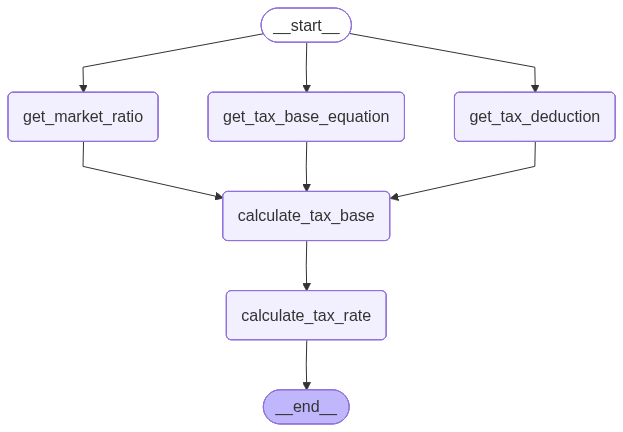

In [16]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"
response = graph.invoke({"query": query})
response

get_market_ratio
get_tax_base_equation
get_tax_deduction
calculate_tax_base
calculate_tax_rate


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'tax_rate': '종합부동산세를 계산해 드릴께요!\n\n과세 표준: 주택 공시가격은 50억원인 집 1 채, 100억 원인 집 1 채, 200억 원인 집 1 채입니다.\n\n주택 수: 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있습니다.\n\n과세 표준의 합계는 (50억 + 100억 + 200억) = 350억입니다.\n\n납세의무자가 3 주택 이상을 소유한 경우 세율은 1.25% 인가요?\n\n따라서 종합부동산세를 계산해 드리겠습니다!\n\n공제 금액 = 공시 가격 × (1.25%)\n= (50억 + 100억 + 200억) × 0.0125\n= 350억 × 0.0125\n= 4,375 억\n\n종합부동산세의 세액은 과세 표준과 공제 금액을 계산해 드리겠습니다!\n\n1. 첫 번째 집 (5억 원): 공시 가격 = 50억, 전용면적 × 공시 가격 = 50억 × 0.0125 = 625 만\n2. 두 번째 집 (10억 원): 공시 가격 = 100억, 전용면적 × 공시 가격 = 100억 × 0.0125 = 1,250 만\n3. 세 번째 집 (20억 원): 공시 가격 = 200억, 전용면적 × 공시 가격 = 200억 × 0.0125 = 2,500 만\n\n종합부동산세의 세액은 총 4,375 억입니다.\n\n납세의무자가 3 주택 이상을 소유한 경우 종합부동산세는 4,375 억이 됩니다!\n\n아래는 계산 결과를 요약해 드리겠습니다:\n\n* 첫 번째 집 (5억 원): 공제 금액 = 625 만\n* 두 번째 집 (10억 원): 공제 금액 = 1,250 만\n* 세 번째 집 (20억 원): 공제 금액 = 2,500 만\n\n이 계산 결과를 사용하시면 종합부동산세를 정확하게 계산하실 수 있습니다!\n\n궁금한 점 있으시면 언제든지 물어보세요!',
 'tax_base': '주택 공시가격은 5억원인 집 1 채, 10억 원인 집

In [18]:
print(response["tax_rate"])  # answer

종합부동산세를 계산해 드릴께요!

과세 표준: 주택 공시가격은 50억원인 집 1 채, 100억 원인 집 1 채, 200억 원인 집 1 채입니다.

주택 수: 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있습니다.

과세 표준의 합계는 (50억 + 100억 + 200억) = 350억입니다.

납세의무자가 3 주택 이상을 소유한 경우 세율은 1.25% 인가요?

따라서 종합부동산세를 계산해 드리겠습니다!

공제 금액 = 공시 가격 × (1.25%)
= (50억 + 100억 + 200억) × 0.0125
= 350억 × 0.0125
= 4,375 억

종합부동산세의 세액은 과세 표준과 공제 금액을 계산해 드리겠습니다!

1. 첫 번째 집 (5억 원): 공시 가격 = 50억, 전용면적 × 공시 가격 = 50억 × 0.0125 = 625 만
2. 두 번째 집 (10억 원): 공시 가격 = 100억, 전용면적 × 공시 가격 = 100억 × 0.0125 = 1,250 만
3. 세 번째 집 (20억 원): 공시 가격 = 200억, 전용면적 × 공시 가격 = 200억 × 0.0125 = 2,500 만

종합부동산세의 세액은 총 4,375 억입니다.

납세의무자가 3 주택 이상을 소유한 경우 종합부동산세는 4,375 억이 됩니다!

아래는 계산 결과를 요약해 드리겠습니다:

* 첫 번째 집 (5억 원): 공제 금액 = 625 만
* 두 번째 집 (10억 원): 공제 금액 = 1,250 만
* 세 번째 집 (20억 원): 공제 금액 = 2,500 만

이 계산 결과를 사용하시면 종합부동산세를 정확하게 계산하실 수 있습니다!

궁금한 점 있으시면 언제든지 물어보세요!
